# Categorización de reseñas de películas clásicas

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es detectar las críticas negativas de forma automática. 

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Inicialización](#inicializacion)
* [Cargando los datos](#cargando_los_datos)
* [Explorando los datos](#explorando_datos_iniciales)
* [Equilibrio de clases](#equilibrio)
* [Preprocesamiento de datos](#preparacion_de_datos)
* [Análisis exploratorio de datos](#eda)
* [Procedimiento de evaluación](#procediemiento)
* [División entrenamiento / prueba](#division)
* [Trabajar con modelos](#modelo)
* [Mis reseñas](#reseñas)
* [Diferencias entre los resultados](#resultados)
* [Conclusiones](#end)

## Introducción <a id='intro'></a>

**Propósito del proyecto**
    
   - Detectar las críticas de forma automática de reseñas de películas de IMDB.

### Objetivos:
1. - Realizar preprocesamiento de datos para el modelado;
2. - Entrenar modelos diferentes;
3. - Clasifícar algunas reseñas con los modelos entrenados;
4. - Buscar las diferencias entre los resultados de las pruebas de los modelos.

[Volver a Contenidos](#back)

## Inicialización <a id='inicializacion'></a>

In [3]:
import math
import random
import time

import numpy as np
import pandas as pd

import re
import nltk
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# esto es para usar progress_apply
tqdm.pandas()

## Cargando datos <a id='cargando_los_datos'></a>

In [6]:
# leyendo el archivo y almacenándolo en df
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Explorando los datos <a id='explorando_datos_iniciales'></a>

**Descripción de datos**

In [7]:
df_reviews.shape

(47331, 17)

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
df_reviews.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
95%,2007.000000,0.000000,8.000000,1.129690e+05,10.000000,1.000000,11868.000000
99%,2008.000000,0.000000,8.700000,3.877170e+05,10.000000,1.000000,12376.700000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [10]:
df_reviews.describe(exclude=['int', 'float'])

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0072752,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


In [11]:
# Imprime una muestra de los datos
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


**Valores ausentes**

In [12]:
df_reviews.isna().sum().sort_values(ascending=False)

average_rating     2
votes              2
tconst             0
ds_part            0
pos                0
sp                 0
rating             0
review             0
genres             0
title_type         0
is_adult           0
runtime_minutes    0
end_year           0
start_year         0
original_title     0
primary_title      0
idx                0
dtype: int64

**Valores duplicados**

In [13]:
len(df_reviews.drop_duplicates()) == len(df_reviews)

True

In [14]:
# Eliminado valores duplicados
df_reviews.dropna(subset=["average_rating"], inplace=True)
df_reviews.dropna(subset=["votes"], inplace=True)

**Valores únicos**

In [15]:
df_reviews['pos'].sort_values().unique()

array([0, 1])

In [16]:
df_reviews['ds_part'].sort_values().unique()

array(['test', 'train'], dtype=object)

**Conclusión intermedia**
 - El DataFrame **df_reviews** tiene 47.331 filas y 17 columnas. Con valores ausentes en *average_rating* y *votes* que fueron eliminados. No hay valores duplicados.

[Volver a Contenidos](#back)

## **Equilibrio de clases**  <a id='equilibrio_de_clases'></a>

In [17]:
#Examinando el equilibrio de clases
df_reviews["ds_part"].value_counts(normalize = True)

train    0.502778
test     0.497222
Name: ds_part, dtype: float64

In [18]:
desequilibrio = (0.502757 - 0.497243) / (0.502757)
desequilibrio

0.010967525066781803

**Conclusión intermedia**
 - El desequilibrio es muy pequeño, por lo cuál no hay que aplicar ninguna técnica para equilibrar las clases.
 
[Volver a Contenidos](#back)

## Preprocesamiento de datos <a id='preparacion_de_datos'></a>

### Limpiando y lematizando los datos

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def clear_text(text):
    
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    
    return clean_text

def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [21]:
# Aplicando la función 'clear_text' a cada valor en la columna 'df_reviews["review"]'
clean_reviews = df_reviews["review"].apply(clear_text)

In [22]:
%%time
# Aplicando la función 'lemmatize' a la serie 'clean_reviews'
lemmatized_reviews = clean_reviews.apply(lemmatize)

CPU times: user 16min 47s, sys: 4.14 s, total: 16min 51s
Wall time: 16min 52s


In [23]:
# Creando una nueva columna en el DataFrame 'df_reviews' y almacenando las reseñas lematizadas en ella
df_reviews["lemmatized_review"] = lemmatized_reviews

In [24]:
example = 5
text1 = df_reviews.loc[example, "review"]
text1

"This is the first movie I've seen from Singapore and it's great. If you don't know a lot about Asia, its languages and its culture, then this film may be a bit confusing for the non-informed people. As an Asian-American who's double majoring in two Asian languages (one of them being Mandarin) and has taken some Asian American Studies classes, this film was easier for me to understand, but even without that kind of knowledge, I believe this movie is still accessible to its foreign audiences as long as you keep in mind that it's a coming-of-age type of movie. The film is definitely worth seeing just so that you get the chance to see what kind of issues Singapore's young teenage boys are struggling and having to deal with. This is an awesome coming-of-age movie, but filmed and shown in a more artistic and original way. The actors are outstanding."

In [25]:
example = 5
text2 = df_reviews.loc[example, "lemmatized_review"]
text2

"this be the first movie I 've see from singapore and it be great if you do not know a lot about asia its language and its culture then this film may be a bit confusing for the non informed people as an asian american who be double majoring in two asian language one of they be mandarin and have take some asian american study class this film be easy for I to understand but even without that kind of knowledge I believe this movie be still accessible to its foreign audience as long as you keep in mind that it be a coming of age type of movie the film be definitely worth see just so that you get the chance to see what kind of issue singapore 's young teenage boy be struggle and have to deal with this be an awesome come of age movie but film and show in a more artistic and original way the actor be outstanding"

### Bolsa de palabras y N-gramas

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stop_words = set(stopwords.words('english'))

In [29]:
count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2)) #OK

In [30]:
n_gram = count_vect.fit_transform(lemmatized_reviews) #OK
n_gram.shape

(47329, 2628150)

**Conclusión**

Al aplicar la lematización se crearon 2.628.150 columnas, por lo cuál, más adelante se aplicarán parámetros.

### TF-IDF

In [32]:
df_reviews_train = df_reviews[df_reviews["ds_part"] == "train"]["lemmatized_review"].copy()
df_reviews_test = df_reviews[df_reviews["ds_part"] == "test"]["lemmatized_review"].copy()

In [33]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_features = 10000, lowercase=True) #agregar max_features 5000 o 10000

In [34]:
count_train_tf_idf = count_tf_idf.fit_transform(df_reviews_train)
count_train_tf_idf.shape

(23796, 10000)

In [35]:
count_test_tf_idf = count_tf_idf.transform(df_reviews_test)
count_test_tf_idf.shape

(23533, 10000)

**Conclusión**

Al aplicar los parámetros, las columnas de redujeron a 10.000.

## Análisis exploratorio de datos <a id='eda'></a>

**Vislumbrando el número de películas y reseñas a lo largo de los años**

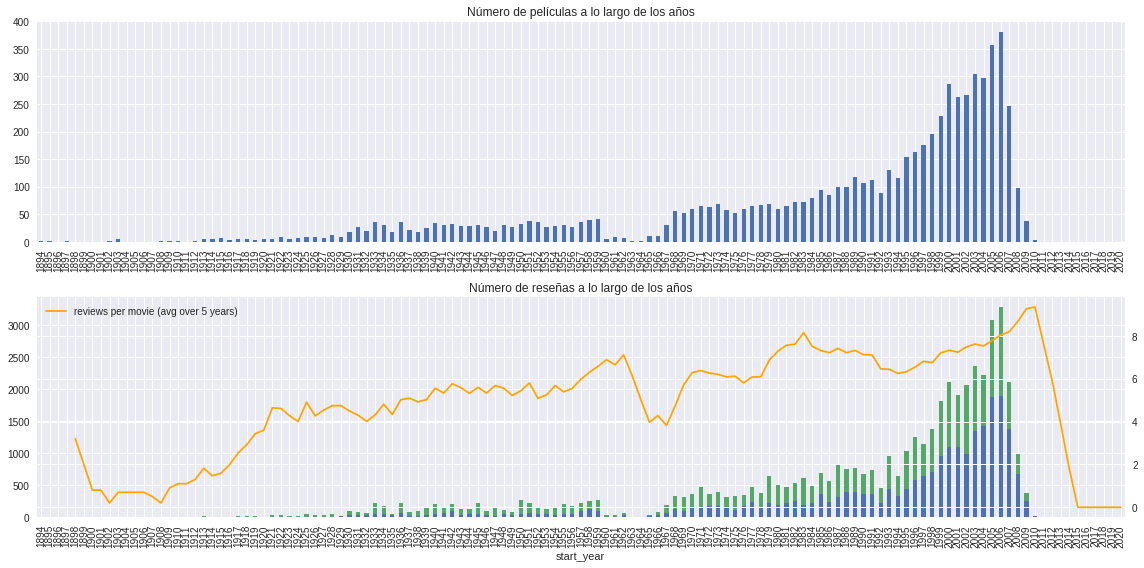

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Conclusión intermedia**

*Gráfico "Número de películas a lo largo de los años"*
 - Se empieza a ver un incremento en el año 1.981 de peliculas, teniendo un máximo en el año 2.005 - 2.006.
 
*Gráfico "Número de reseñas a lo largo de los años"*
 - El promedio de reseñas es entre 2.000 - 2.500, en los años donde se evidencia el incremento de películas.
 
[Volver a Contenidos](#back)

**Distribución del número de reseñas por película**

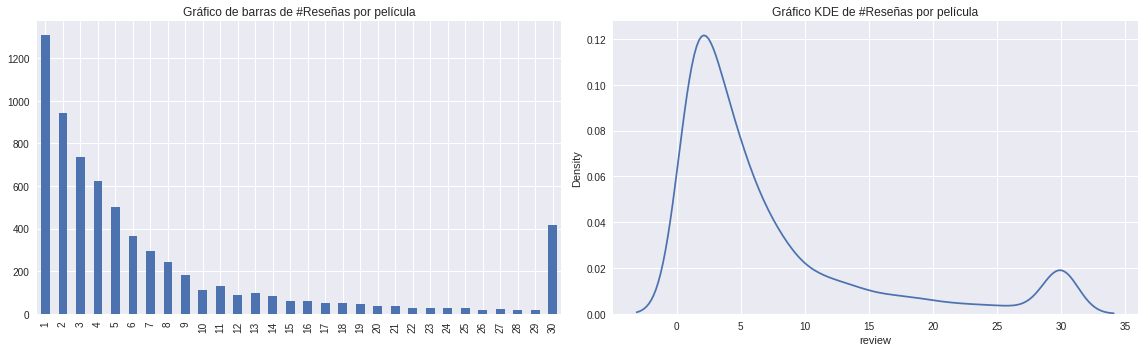

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Conclusión intermedia**

*Gráfico "Gráfico de barras de #Reseñas por película"*
 - El número de ocurrencia de cada numero de reseñas, se uede observar que las primeras cinco tienen los mayores valores.
 
*Gráfico "Gráfico KDE de #Reseñas por película"*
 - La distribución de la reseña se puede decir que es normal, con una media alrededor de 3.
 
[Volver a Contenidos](#back)

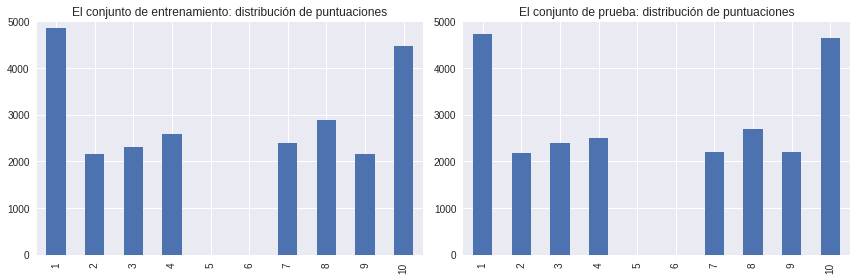

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Conclusión intermedia**

*Gráfico "El conjunto de entrenamiento: distribución de puntuaciones"*
 - Se evidencia que el número de reseñas para cada puntuación del rating, el N° 1 y el 10° son los que tiene mayor puntuación para el conjunto de entrenamiento.
 
*Gráfico "El conjunto de prueba: distribución de puntuaciones"*
 - Parecido al gráfico anterior, se evidencia que el número de reseñas para cada puntuación del rating, el N° 1 y el 10° son los que tiene mayor puntuación para el conjunto de entrenamiento.
 
[Volver a Contenidos](#back)

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


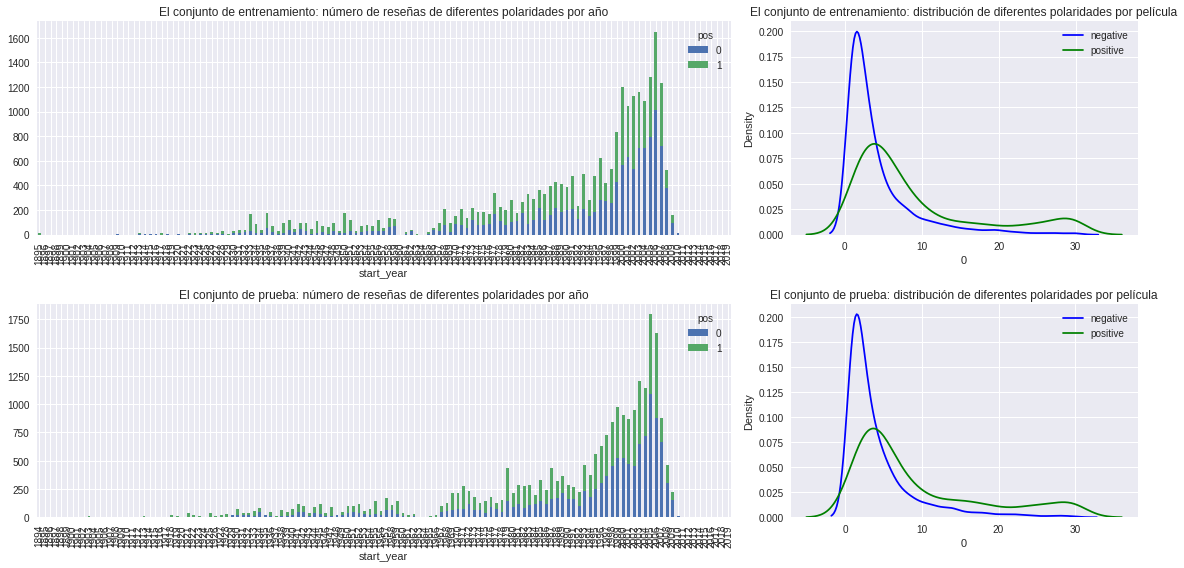

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**Conclusión intermedia**

*Gráfico "El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año"*
 - En el conjunto de entrenamiento se evidencia menor número de reseñas positivas desde el año 1.999 al 2.007, comparado a las reseñas negativas.
 
*Gráfico "El conjunto de entrenamiento: distribución de diferentes polaridades por película"*
 - Las reseñas negativas tienen una distribución más concentrada, con la probabilidad de tener puntuación entre 1 -2. Las reseñas positivas, tienen una distribución más dispersa, con la probabilidad de tener una puntuación de 5.
 
*Gráfico "El conjunto de prueba: número de reseñas de diferentes polaridades por año"*
 - Parecido al gráfico anterior, se evidencia que el conjunto de entrenamiento es menor número de reseñas positivas desde el año 1.999 al 2.007, comparado a las reseñas negativas. Sin embargo, si comparamos ambos gráficos, las reseñas positivas son mayores en el conjunto de entrenamiento.

*Gráfico "El conjunto de prueba: distribución de diferentes polaridades por película"*
 - Muy parecido al gráfico anterior, las reseñas negativas tienen una distribución más concentrada, con la probabilidad de tener puntuación entre 1 -2. Las reseñas positivas, tienen una distribución más dispersa, con la probabilidad de tener una puntuación de 5.

[Volver a Contenidos](#back)

## Procedimiento de evaluación <a id='procedimiento'></a>

**Composición de una rutina de evaluación**

In [42]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target, model_name=""):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## División entrenamiento / prueba <a id='division'></a>

In [47]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#df_reviews_train = df_reviews[df_reviews["ds_part"] == "train"]["lemmatized_review"].copy()
#df_reviews_test = df_reviews[df_reviews["ds_part"] == "test"]["lemmatized_review"].copy()

train_target = df_reviews_train['pos']
#train_target = df_reviews[df_reviews["ds_part"] == "train"]["pos"]
test_target = df_reviews_test['pos']
#test_target = df_reviews[df_reviews["ds_part"] == "test"]["pos"]

print(train_target.shape)
print(test_target.shape)

(23796,)
(23533,)


In [48]:
#Examinando el equilibrio de clases
train_target.value_counts(normalize = True)

0    0.500588
1    0.499412
Name: pos, dtype: float64

In [49]:
#Examinando el equilibrio de clases
test_target.value_counts(normalize = True)

0    0.501551
1    0.498449
Name: pos, dtype: float64

## Trabajar con modelos <a id='modelos'></a>

**Modelos a entrenar Logistic Regression, LGBM Classifier y Dummy Classifier**

In [50]:
random_state = 200

In [51]:
lr_model = LogisticRegression(max_iter=100, random_state=random_state)
lgbm_model = LGBMClassifier(learning_rate=0.1, random_state=random_state)
classifier_model = DummyClassifier(strategy='most_frequent')

In [52]:
%%time
lr_model.fit(count_train_tf_idf, train_target)

CPU times: user 2.17 s, sys: 3.62 s, total: 5.79 s
Wall time: 5.78 s


LogisticRegression(random_state=200)

In [53]:
%%time
lgbm_model.fit(count_train_tf_idf, train_target)

CPU times: user 1min, sys: 470 ms, total: 1min
Wall time: 1min


LGBMClassifier(random_state=200)

In [54]:
%%time
classifier_model.fit(count_train_tf_idf, train_target)

CPU times: user 2.41 ms, sys: 24 µs, total: 2.43 ms
Wall time: 1.5 ms


DummyClassifier(strategy='most_frequent')

In [55]:
models = {
    "logistic": lr_model,
    "lgbm": lgbm_model,
    "classifier": classifier_model,
}

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.94
ROC AUC    0.97  0.94
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


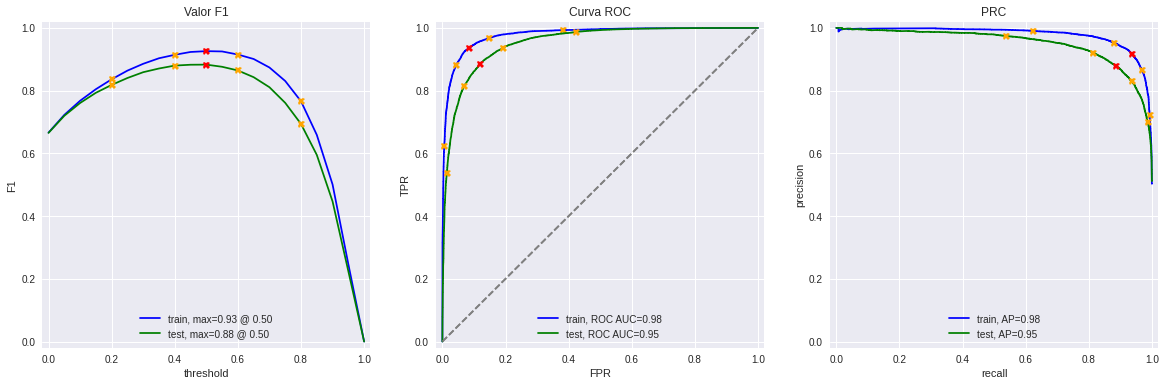

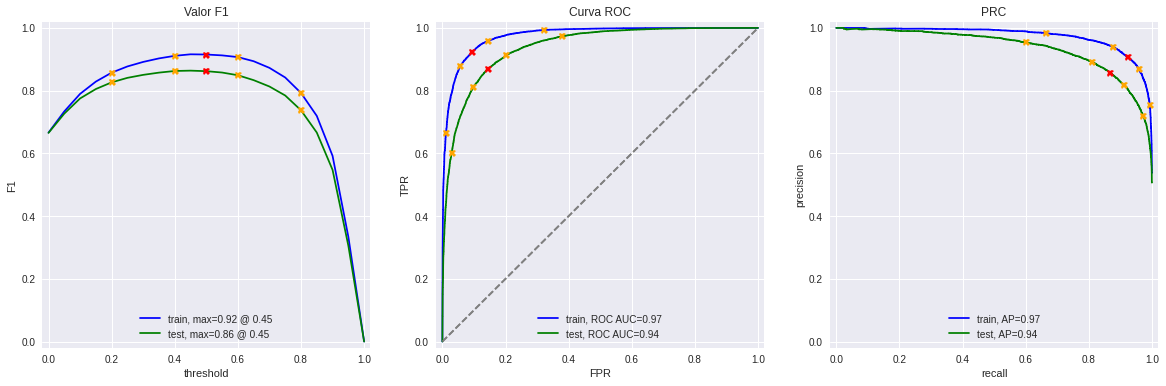

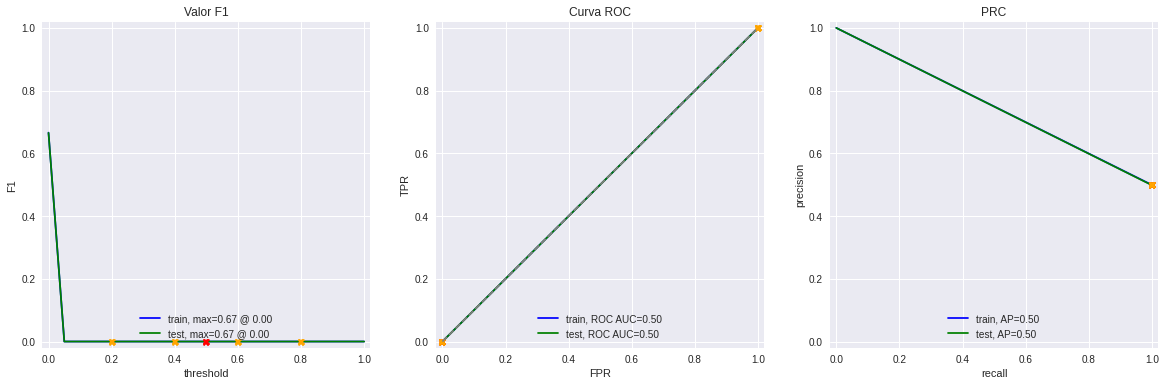

In [56]:
for model_name, model in models.items():

  evaluate_model(model,
                 count_train_tf_idf,
                 train_target,
                 count_test_tf_idf,
                 test_target,
                 model_name)

**Conclusión intermedia**

*Evaluando el modelo:*

**Precisión**
 - Comparando los tres modelos en el conjunto de prueba, quien predice correctamente el sentimiento de una reseña de película es el modelo Logistic Regression con un 88%.
 
**F1**
 - Comparando los tres modelos en el conjunto de prueba, quien tiene mayor precisión y sensibilidad es el modelo Logistic Regression con un 88%.
 
**APS**
 - Comparando los tres modelos en el conjunto de prueba, quien tiene la capacidad de clasificar las reseñas positivas por encima de las reseñas negativasmayor es el modelo Logistic Regression con un 95%.
 
**ROC AUC**
 - Comparando los tres modelos en el conjunto de prueba, quien tiene la capacidad de discriminar entre reseñas positivas y negativas es el modelo Logistic Regression con un 95%.

[Volver a Contenidos](#back)

## Mis reseñas <a id='reseñas'></a>

In [75]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

"\nmy_reviews = pd.DataFrame([\n    'Simplemente no me gustó, no es mi tipo de película.',\n    'Bueno, estaba aburrido y me quedé dormido a media película.',\n    'Estaba realmente fascinada con la película',    \n    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',\n    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',\n    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',\n    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',\n    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'\n], columns=['review'])\n"

In [76]:
# Aplicando la función 'clear_text' a cada valor en la columna 'df_reviews["review"]'
clean_reviews_2 = my_reviews['review'].apply(clear_text)

In [77]:
# Aplicando la función 'lemmatize' a la serie 'clean_reviews'
lemmatized_reviews_2 = clean_reviews_2.apply(lemmatize)

In [78]:
# Creando una nueva columna en el DataFrame 'df_reviews' y almacenando las reseñas lematizadas en ella
my_reviews["review_norm"] = lemmatized_reviews_2

In [79]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
stop_words_2 = set(stopwords.words('english'))

In [81]:
count_vect_2 = CountVectorizer(stop_words=stop_words_2, ngram_range=(1, 2)) #OK

In [82]:
n_gram_2 = count_vect_2.fit_transform(lemmatized_reviews_2)
n_gram_2.shape

(8, 123)

In [83]:
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))

In [84]:
count_tf_idf_ = count_tf_idf_2.fit_transform(my_reviews)
count_tf_idf_.shape

(2, 2)

### Modelo Logistic Regression

In [85]:
texts = my_reviews['review_norm'] #texto de la reseña normalizado

my_reviews_pred_prob = lr_model.predict_proba(count_tf_idf.transform(texts))[:, 1] #transformando el texto a una representación numérica

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  I do not simply like it not my kind of movie
0.14:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.11:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.15:  I do not expect the reboot to be so good writer really care about the source material
0.36:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.94:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo LGBM Classifier

In [87]:
my_reviews_pred_prob = lgbm_model.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  I do not simply like it not my kind of movie
0.47:  well I be bored and feel asleep in the middle of the movie
0.65:  I be really fascinated with the movie
0.33:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.65:  I do not expect the reboot to be so good writer really care about the source material
0.72:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.32:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.79:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo Dummy Classifier

In [89]:
my_reviews_pred_prob = classifier_model.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  I do not simply like it not my kind of movie
0.00:  well I be bored and feel asleep in the middle of the movie
0.00:  I be really fascinated with the movie
0.00:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.00:  I do not expect the reboot to be so good writer really care about the source material
0.00:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.00:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.00:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


**Conclusión intermedia**

Comparando los tres modelos, el que tiene la probabilidad de que la reseña exprese sentimiento positivo es LGBM Classifier. Con valores entre 0.64 - 0.79.

## Diferencias entre los resultados de las pruebas de los modelos <a id='diferencias'></a>

In [93]:
obs_idx = 18

obs = df_reviews_test.iloc[obs_idx]
obs_data = count_test_tf_idf[obs_idx]
print(f"Text: {obs.review}, target: {obs.pos}")

for model_name, model in models.items():
  print(f"Model: {model_name}, prediction: {model.predict(obs_data)}")

Text: If anything, William Girdler was an opportunist who wanted a piece of the action in regards to whatever was popular during the time. I mean, a blaxploitation flick in Louisville, Kentucky..who would of thunk it?!?! I can just imagine the enthusiasm he must've had getting Pam Grier, quite a hot item, to star in his picture. If you are pretty familiar with the genre, Girdler's Sheba, Baby doesn't necessarily stray too far from formula. Despite a change of venue, the film still deals with a ruthless businessman nicknamed Shark who muscles in on loan companies, using stooges to threaten them in order to get their signatures. Grier is Sheba Shayne, a former Louisville cop working in Chicago who returns home at the request of her father's partner, Brick(Austin Stoker, Assault on Precinct 13). Sheba's father, despite Shark's bullying tactics(..his man in town is Pilot, a wannabe gangster, equipped with stooges who aren't that menacing, rather buffoonish in nature, so thin-skinned they h

**Conclusión intermedia**

Los modelos Logistic Regression y LGBM Classifier predicen que el sentimiento de la reseña es positivo [1], mientras que Dummy Classifier es negativo [0].

## Conclusiones <a id='end'></a>

Se inició el proyecto explorando los datos donde el DataFrame df_reviews tiene 47.331 filas y 17 columnas. Con valores ausentes en average_rating y votes que fueron eliminados. No hay valores duplicados. Se examinó un equilibrio de clases, y fue muy pequeño.

Luego, se pre procesan los datos, limpiandolos y lematizandolos, aplicando nltk ya que esto nos permite analizar el significado y extraer información del texto. Se aplicó TF-IDF para asignar un peso a cada palabra.

Se analizaron los datos mediantes gráficos, donde se vislumbra la distribución del número de reseñas por película (positivas/negativas), entre otros.

Se entrenaron los modelos Logistic Regression, LGBM Classifier y Dummy Classifier, evidenciándose que el modelo Logistic Regression:
 - tiene mejor predicción, precisión, sensibilidad y capacidad de discriminar entre reseñas positivas/negativas;
 - tiene la probabilidad de que la reseña exprese sentimiento positivo.
 
Y por último, entre las diferencias de los resultados de las pruebas de los modelos, Logistic Regression y LGBM Classifier predicen que el sentimiento de la reseña es positivo [1], mientras que Dummy Classifier es negativo [0].